Load model with state dict

In [ ]:
import torch
from src.da_model_v4 import DA_model_v4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("checkpoints/best_model_v4_vanilla.pth", map_location=device)
model = DA_model_v4().to(device)
model.load_state_dict(ckpt)
model = model.eval()

Load data

In [2]:
from src.data import source_train_loader, target_train_loader

data_src = iter(source_train_loader) 
(images_s_q, images_s_k, labels_s) = next(data_src) 

data_tgt = iter(target_train_loader) 
(images_t_q, images_t_k, labels_t) = next(data_tgt) 


In [4]:
import matplotlib.pyplot as plt
def visualize_img(img, labels, preds, index=0):
    image_cpu = img[index].cpu().numpy().transpose((1, 2, 0))
    plt.title(f'Label: {labels[index]}, Prediction: {preds[index]}')
    plt.imshow(image_cpu.squeeze())
    plt.axis('off')  # remove axis ticks
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


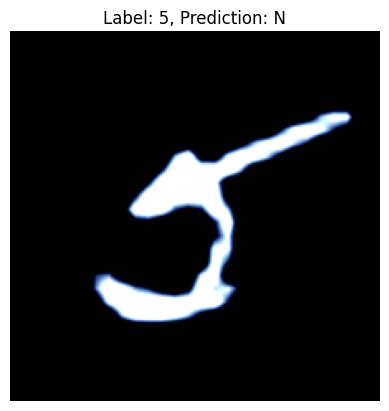

In [24]:
visualize_img(images_s_q, labels_s, "None")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


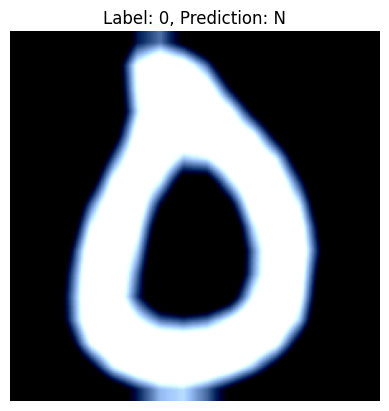

In [25]:
visualize_img(images_t_q, labels_t, "None")

In [7]:
with torch.no_grad():
    images = images_t_q.to(device)
    transformed_images_src_vr = model.src_visual_prompt(images)
    transformed_images_tgt_vr = model.tgt_visual_prompt(images)

AttributeError: 'DA_model_v4' object has no attribute 'src_visual_prompt'

In [23]:
visualize_img(transformed_images_src_vr, labels_t, "1")

NameError: name 'transformed_images_src_vr' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.118177..2.29143].


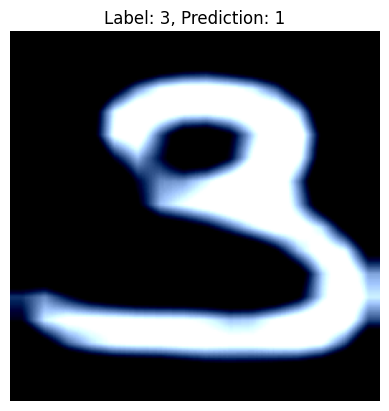

In [8]:
visualize_img(transformed_images_tgt_vr, labels_t, "1")

In [9]:
with torch.no_grad():
    feat_src_vr = model.backbone(transformed_images_src_vr)
    feat_tgt_vr = model.backbone(transformed_images_tgt_vr)

    src_cls_pred = model.src_classifier(feat_src_vr)
    tgt_cls_pred = model.tgt_classifier(feat_tgt_vr)

In [10]:
print(src_cls_pred[0])

tensor([ 0.6119, -1.5981, -0.1991, -0.6012, -2.3645, -0.2023,  4.8495, -2.1431,
        -0.2749, -0.2191], device='cuda:1')


In [11]:
tgt_cls_pred[0]

tensor([-0.3090, -0.0950, -0.2823,  0.2687,  0.2097,  0.3529, -0.7079,  0.3655,
         0.3089,  0.0699], device='cuda:1')

In [12]:
import torch.nn.functional as F
probabilities = F.softmax(src_cls_pred, dim=1)

# Get the predicted labels (argmax over classes) and their confidence values (max probability)
confidences, predicted_labels = torch.max(probabilities, dim=1)

In [7]:
from src.data import target_test_loader
import torch.nn as nn

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # During evaluation, we need only the classification head.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            feat = model.backbone(model.src_visual_prompt(images))
            pred = model.src_classifier(feat)

            # Set alpha = 0 so that GRL does not affect the output.
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [9]:
def evaluate_tgt(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # During evaluation, we need only the classification head.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            feat = model.backbone(model.tgt_visual_prompt(images))
            pred = model.src_classifier(feat)

            # Set alpha = 0 so that GRL does not affect the output.
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [3]:
def evaluate_tgt_v4(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # During evaluation, we need only the classification head.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            feat = model.backbone(model.visual_prompt(images))
            pred = model.classifier(feat)

            # Set alpha = 0 so that GRL does not affect the output.
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [5]:
def evaluate_wo_vr(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # During evaluation, we need only the classification head.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            feat = model.backbone(images)
            pred = model.src_classifier(feat)

            # Set alpha = 0 so that GRL does not affect the output.
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [4]:
def evaluate_wo_vr_v4(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # During evaluation, we need only the classification head.
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            feat = model.backbone(images)
            pred = model.classifier(feat)

            # Set alpha = 0 so that GRL does not affect the output.
            loss = criterion(pred, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(pred, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [5]:
evaluate(model, target_test_loader, device)

NameError: name 'evaluate' is not defined

In [8]:
evaluate_tgt_v4(model, target_test_loader, device)

(1.8074349753584622, 54.01096163428002)

In [9]:
evaluate_wo_vr_v4(model,target_test_loader, device)

(1.8074349753584622, 54.01096163428002)